# Trabajo Práctico 1: Clasificación sobre datos simulados


## Tabla de Contenidos 

- [0. Introducción](#intro)
    - [0.1. Paquetes](#paquetes)
    - [0.2. Datos](#datos)
- [1. Separación de datos](#separacion)
    - [1.1. Random State](#randomstate)
    - [1.2. Stratify](#stratify)
    - [1.3. Features](#features)
- [2. Construcción de modelos](#modelos)
    - [2.1. Árbol de decidión](#arbol)
    - [2.2. CV](#cv)
    - [2.3. Criterios de corte](#criterios)
    - [2.4. Implementación manual (Extra)](#manual)
- [3. Comparación de algoritmos](#algoritmos)
    - [3.1. Hiperparámetros](#hiperparametros)
    - [3.2. Grid Search CV](#gridsearch)
    - [3.3. Randomized Search CV (Extra)](#randomizedsearch)
- [4. Diagnóstico sesgo-varianza](#diagnostico)
    - [4.1. Curvas de complejidad](#complejidad)
    - [4.2. Curvas de aprendizaje](#aprendizaje)
    - [4.3. Ensambles: Random Forest](#randomforest)
    - [4.4. Ensambles: Gradient Boosting (Extra)](#gradientboosting)
- [5. Competencia](#competencia)
- [6. Entrega](#entrega)

<a name="intro"></a>
## 0. Introducción

Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 

<a name="paquetes"></a>
### 0.1. Paquetes

Cargamos los paquetes y las configuraciones que vamos a utilizar

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC
import sklearn.svm
import sklearn.ensemble
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import sklearn.model_selection
#from sklearn.model_selection import GridSearchCV
import sklearn.pipeline

from scipy.stats import randint as sp_randint

Y también algunas funciones

In [2]:
def print_grid(grid):
    print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
    print('Modelo:', grid.best_estimator_)

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

<a name="datos"></a>
### 0.2. Datos

Cargamos los datos como data frames de pandas y los visualizamos para las configuraciones de display previamente seteadas

In [3]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 
    
#X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
#y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


Tenemos entonces datos en la matriz "X" de 500 instancias, donde cada instancia representa a un minion. Cada instancia (minion) está caracterizado con 200 atributos (features). El vector "y" asigna una variable categórica para cada instancia, indicando la clase a la cual pertence cada minion de acuerdo a si es apto o no, por lo que se trata de un problema de clasificación. Como los datos de entrenamiento están anotados, construiremos un clasificador mediante un entrenamiento supervisado. Queremos inducir una función booleana que determine si un minion es apto (True) o no apto (False), por lo que el tipo de problema es de aprendizaje de conceptos. No conocemos la función objetivo, pero la queremos aproximar mediante alguna hipótesis (modelo) que se ajuste lo suficientemente bien a nuestros datos a partir de aprendizaje inductivo. La tarea a aprender será determinar si un minion es o no apto para concretar el plan para conquistar el mundo; como experiencia disponemos de 500 minions ya etiquetados como aptos y no aptos sobre los cuales entrenar el clasificador; y utilizaremos como medida de performance el área bajo la curva ROC.

## Ejercicio 1

<a name="separacion"></a>
## 1. Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia.

X_dev: (400, 200), y_dev: (400, 1) para desarrollo
X_eval: (100, 200), y_eval: (100, 1) para evaluación


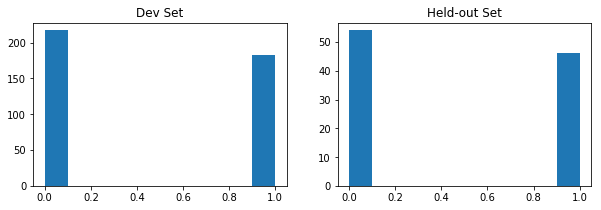

In [4]:
np.random.seed(1234)

X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.title('Dev Set')
plt.subplot(1,2,2)
plt.hist(np.array(y_eval))  # muestra un histograma para la distribución de y.
plt.title('Held-out Set')
plt.show()

Separamos los datos en un set de desarrollo (dev set) y un set de testeo independiente (held-out set). El dev set lo utilizaremos para el análisis de los datos y para entrenamiento del clasificador. El held-out set son los datos que dejamos separados sobre el total de los datos. Este set se mantiene intocable hasta ya tener definido el modelo, para no agregar data leakage, y una vez definido el modelo se utilizará como evaluación de los resultados. De esta manera podremos analizar qué tan generalizable es el clasificador entrenado para la predicción de clases en datos nuevos.

Elegimos que el tamaño del held-out set sea de 0.2 del total de los datos. Consideramos que esta cantidad es óptima para tener una muestra grande de datos para entrenamiento, de manera de aproximar mejor la función objetivo, pero que también deja un set de evaluación lo suficientemente grande como para poder estudiar su generalización. Fijamos el parámetro "random_state" a partir de predefinir una semilla con el comando "np.random.seed(1234)". De esta manera, fijamos la aleatoriedad de como el split separa los datos, obteniendo la misma separación cada vez que se corra la celda. Para que ambos sets sean representativos de la muestra total de los datos elegimos fijar el parámetro "stratify" de manera tal que dichos sets conserven el balance de clases presente en el conjunto total de datos.

<a name="randomstate"></a>
### 1.1. Random State

Para observar el efecto del parámetro random state, realizamos varias corridas dejandolo aleatorio y fijando una semilla y comparamos los indices obtenidos para cada separación de sets.

In [5]:
random_dev_index = []
random_eval_index = []
fixed_dev_index = []
fixed_eval_index = []
for random_iter in range(0,5):
    X_dev_random, X_eval_random, y_dev_random, y_eval_random = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify = y)
    random_dev_index.append(y_dev_random.index.ravel())
    random_eval_index.append(y_eval_random.index.ravel())
    X_dev_fixed, X_eval_fixed, y_dev_fixed, y_eval_fixed = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify = y, random_state=1234)
    fixed_dev_index.append(y_dev_fixed.index.ravel())
    fixed_eval_index.append(y_eval_fixed.index.ravel())

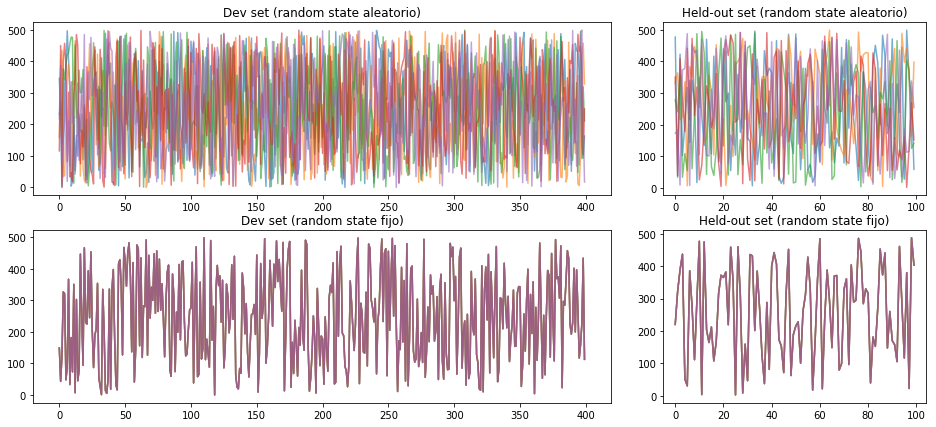

In [6]:
plt.figure(figsize=(16,7))
plt.subplot(2,3,(1, 2))
plt.plot(np.array(random_dev_index).T, alpha=0.6)
plt.title('Dev set (random state aleatorio)')
plt.subplot(2,3,3)
plt.plot(np.array(random_eval_index).T, alpha=0.6)
plt.title('Held-out set (random state aleatorio)')
plt.subplot(2,3,(4, 5))
plt.plot(np.array(fixed_dev_index).T, alpha=0.6)
plt.title('Dev set (random state fijo)')
plt.subplot(2,3,6)
plt.plot(np.array(fixed_eval_index).T, alpha=0.6)
plt.title('Held-out set (random state fijo)')
plt.show()

Cuando dejamos el random state aleatorio observamos que los indices resultantes de la separación de datos dan distinto para todas las corridas, mientras que cuando fijamos la semilla del random state los indices dan siempre igual.

<a name="stratify"></a>
### 1.2. Stratify

Para obsevar el efecto del parámetro stratify, realizamos varias corridas definiendolo de manera tal que las muestras de los sets de separación tengan el mismo balance que la muestra total y dejandolo libre, y comparamos

In [7]:
nonstrat_dev_sum = []
nonstrat_eval_sum = []
strat_dev_sum = []
strat_eval_sum = []
for random_iter in range(0,5):
    X_dev_nonstrat, X_eval_nonstrat, y_dev_nonstrat, y_eval_nonstrat = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    nonstrat_dev_sum.append([np.sum(y_dev_nonstrat == 0)[0],np.sum(y_dev_nonstrat == 1)[0]])
    nonstrat_eval_sum.append([np.sum(y_eval_nonstrat == 0)[0],np.sum(y_eval_nonstrat == 1)[0]])
    X_dev_strat, X_eval_strat, y_dev_strat, y_eval_strat = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify = y)
    strat_dev_sum.append([np.sum(y_dev_strat == 0)[0],np.sum(y_dev_strat == 1)[0]])
    strat_eval_sum.append([np.sum(y_eval_strat == 0)[0],np.sum(y_eval_strat == 1)[0]])

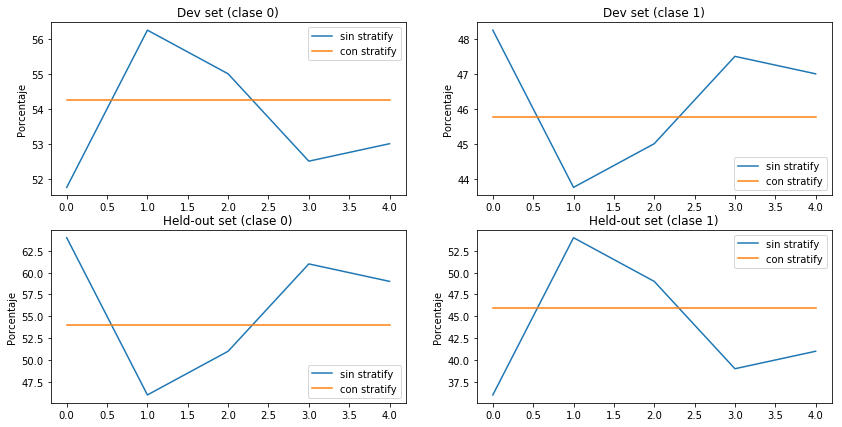

In [8]:
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.plot(pd.DataFrame(nonstrat_dev_sum)[0]/len(y_dev)*100)
plt.plot(pd.DataFrame(strat_dev_sum)[0]/len(y_dev)*100)
plt.legend(('sin stratify','con stratify'))
plt.ylabel('Porcentaje')
plt.title('Dev set (clase 0)')
plt.subplot(2,2,2)
plt.plot(pd.DataFrame(nonstrat_dev_sum)[1]/len(y_dev)*100)
plt.plot(pd.DataFrame(strat_dev_sum)[1]/len(y_dev)*100)
plt.legend(('sin stratify','con stratify'))
plt.ylabel('Porcentaje')
plt.title('Dev set (clase 1)')
plt.subplot(2,2,3)
plt.plot(pd.DataFrame(nonstrat_eval_sum)[0]/len(y_eval)*100)
plt.plot(pd.DataFrame(strat_eval_sum)[0]/len(y_eval)*100)
plt.legend(('sin stratify','con stratify'))
plt.ylabel('Porcentaje')
plt.title('Held-out set (clase 0)')
plt.subplot(2,2,4)
plt.plot(pd.DataFrame(nonstrat_eval_sum)[1]/len(y_eval)*100)
plt.plot(pd.DataFrame(strat_eval_sum)[1]/len(y_eval)*100)
plt.legend(('sin stratify','con stratify'))
plt.ylabel('Porcentaje')
plt.title('Held-out set (clase 1)')
plt.show()

Observamos que cuando le fijamos el parámetro stratify, los sets están siempre igual de balanceados, y que cuando dejamos este parámetro libre, no. La suma de los porcentajes de ambas clases dan el total de los datos de cada set. Cuando seteamos el parámetro stratify, el balance de datos de los sets es el mismo que el de la muestra total.

In [9]:
print('En la muestra total tenemos {:.2f}% de clase 0 y {:.2f}% de clase 1'.format(np.sum(y==0)[0]/len(y)*100, np.sum(y==1)[0]/len(y)*100))

En la muestra total tenemos 54.20% de clase 0 y 45.80% de clase 1


<a name="features"></a>
### 1.3. Features

Nos fijamos la proporción de atributos que son numéricos y la cantidad de elementos vacíos en la matriz de datos de desarrollo

In [10]:
print('La proporción de atributos numéricos es de {:.2f} sobre un total de 1.00'.format(sum(X_dev.dtypes == 'float64')/len(X_dev.dtypes)))
print('La cantidad de elementos vacíos en la matriz de datos es de {} elementos'.format(X_dev.isnull().sum().sum()))

La proporción de atributos numéricos es de 1.00 sobre un total de 1.00
La cantidad de elementos vacíos en la matriz de datos es de 0 elementos


Todos los atributos son numéricos y no hay elementos vacíos.

Hacemos los histogramas para todas las features

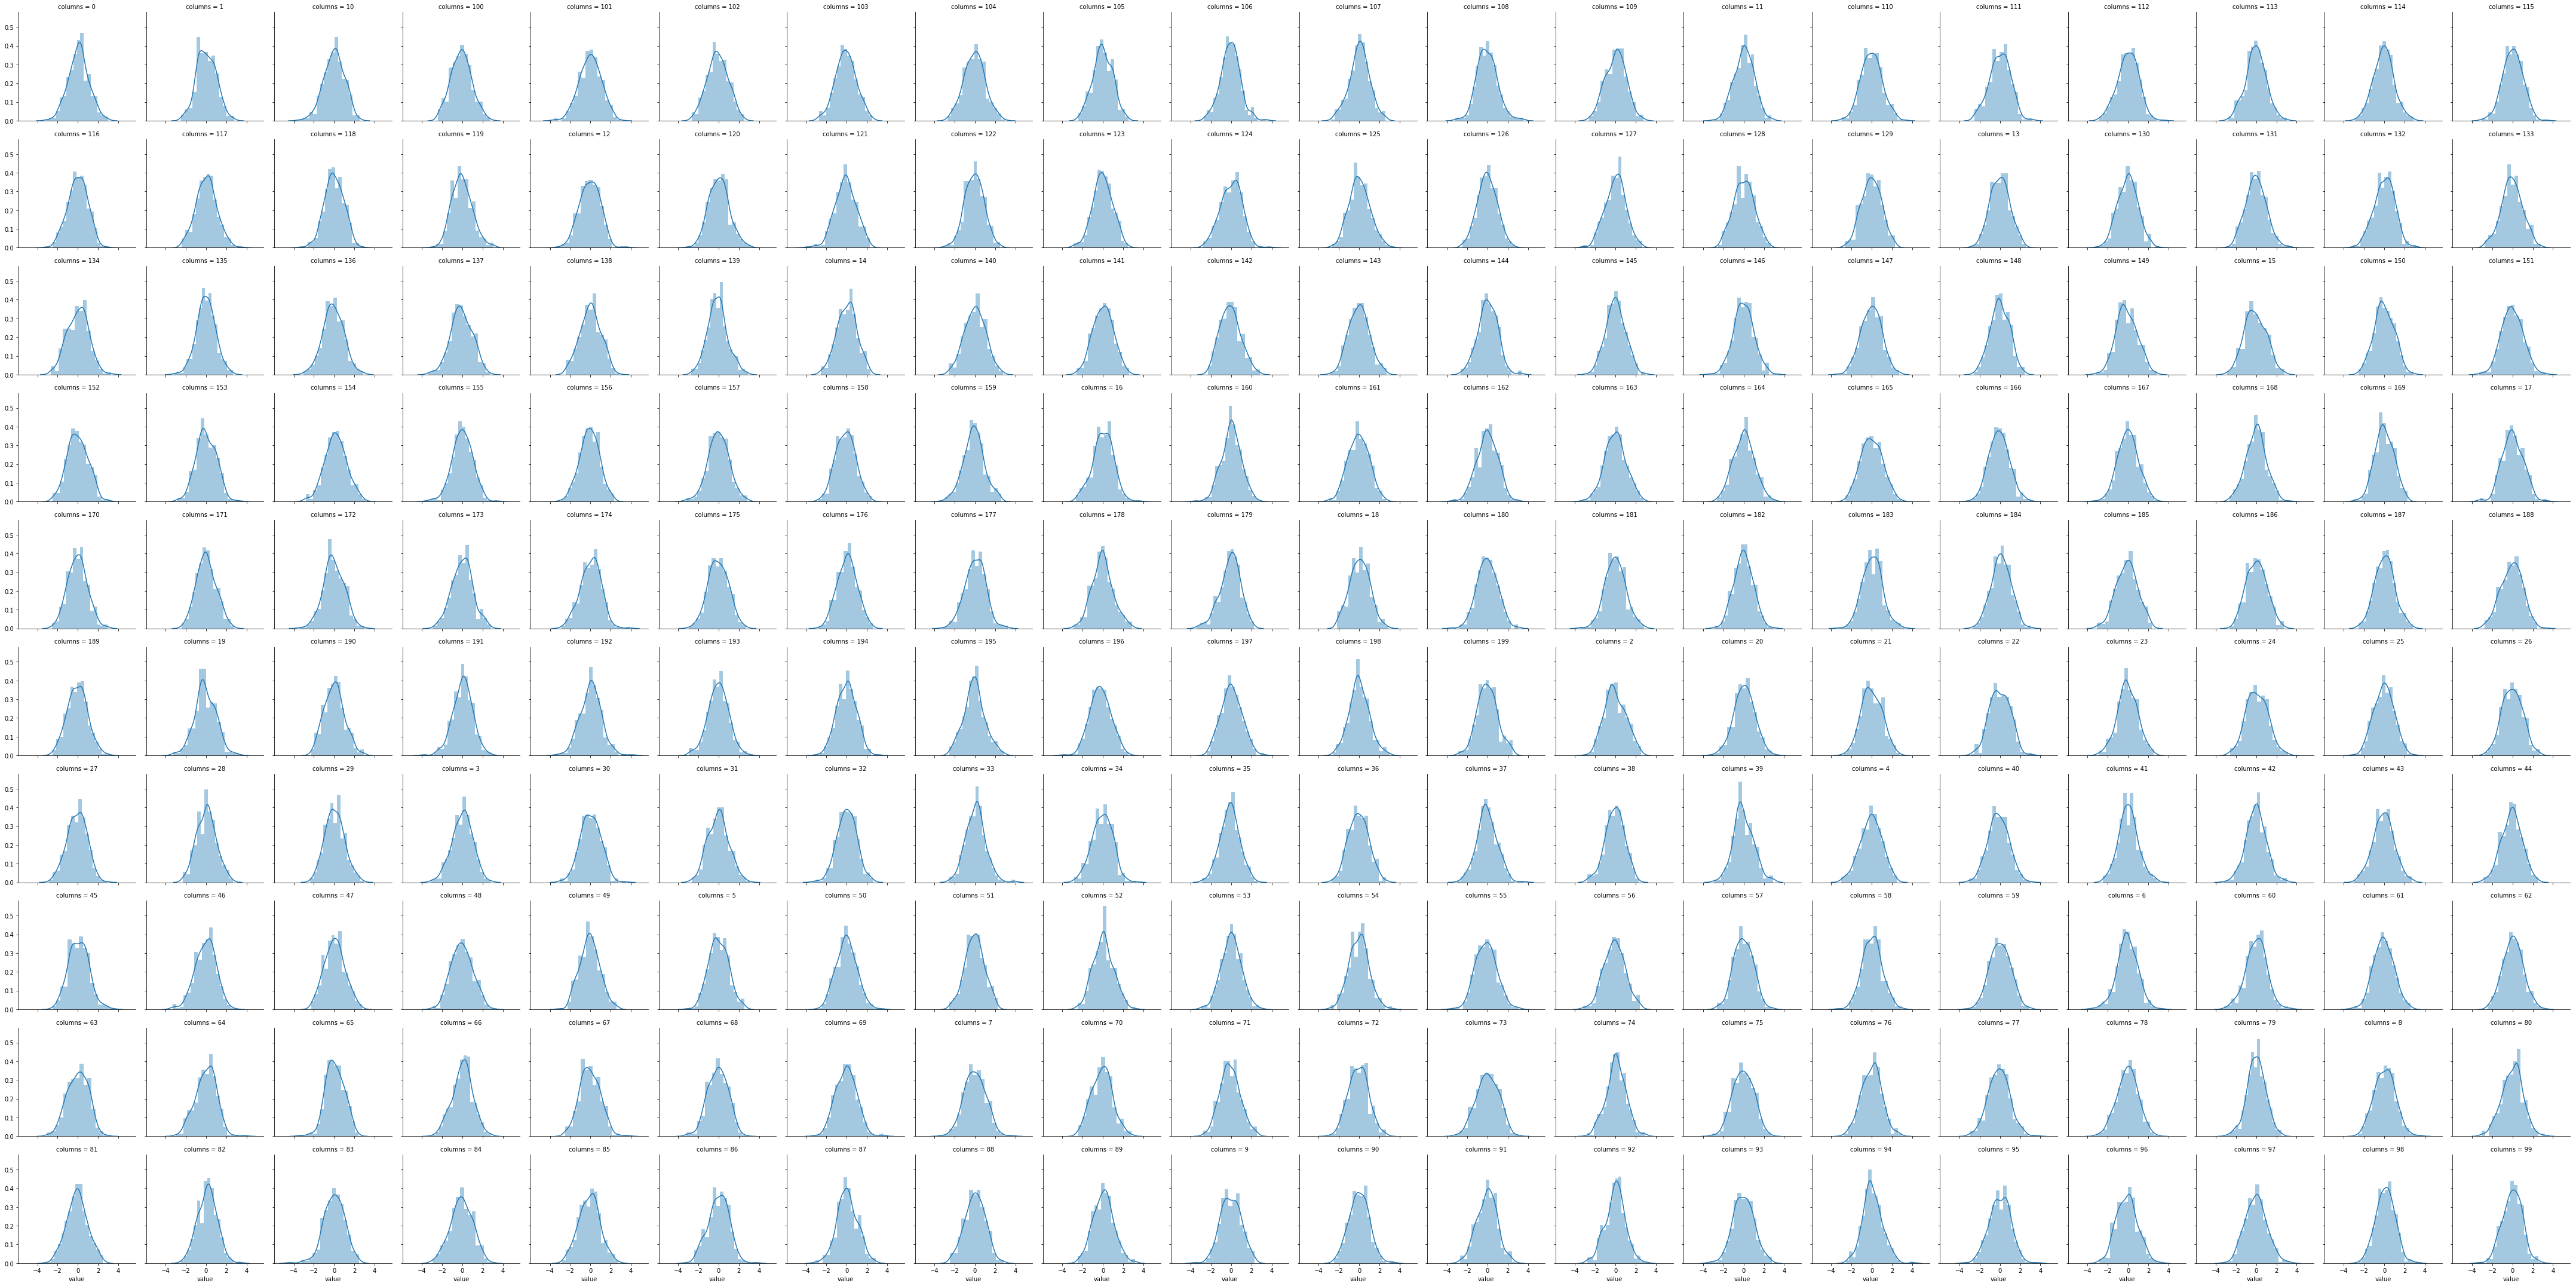

In [11]:
g = sns.FacetGrid(X_dev.melt(var_name='columns'), col='columns', col_wrap=20)
g = (g.map(sns.distplot, 'value'))

Obsevamos que todos los atributos parecen tener distribuciones bastante normales y no parecen tener grandes diferencias de escalas. Si las distribuciones mostraran un skewness significativo, se podría aplicar el logaritmo a los valores y reducir esta tendencia. También se podrían aplicar otras transformaciones a los atributos, o rescalar, o seleccionar sólo algunos atributos, de manera de mejorar el entrenamiento del clasificador. Sin embargo, por tratarse de un trabajo introductorio no vamos a aplicar técnicas de ingeniería de features ni a hacer una selección de atributos y vamos a usar los datos como vienen.

## Ejercicio 2
<a name="modelos"></a>
## 2. Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

<a name="arbol"></a>
### 2.1. Árbol de decisión

Entrenamos un árbol de decisión con altura máxima de 3

In [12]:
arbol = DecisionTreeClassifier(max_depth=3)
arbol.fit(X_dev, y_dev)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Para este clasificador podemos obtener su curva ROC sobre los datos de entrenamiento

ROC AUC:  0.868248092468082


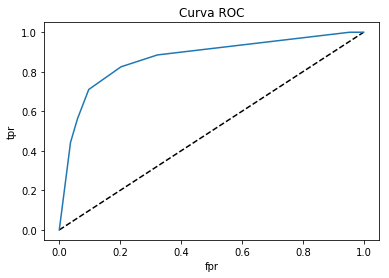

In [13]:
y_pred_proba = arbol.predict_proba(X_dev)[:,1]
fpr, tpr, thresholds = roc_curve(y_dev, y_pred_proba)
print('ROC AUC: ', roc_auc_score(y_dev,y_pred_proba))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Curva ROC')
plt.show()

<a name="cv"></a>
### 2.2. CV

Hacemos una validación cruzada (5-fold CV) estratificada para que cada subset tenga el mismo balance de datos que los datos del dev set

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8245,0.6296,0.8200,0.6204
2,0.8464,0.7407,0.8418,0.7377
3,0.8406,0.6875,0.8325,0.6697
4,0.8255,0.6962,0.8248,0.6983
5,0.8442,0.6835,0.8421,0.6822


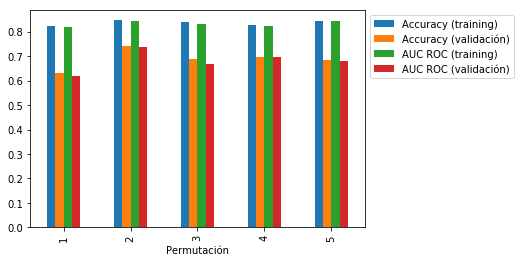

In [14]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

np.random.seed(SEED) # esto lo agregamos para fijar el random state

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
splits = cv.split(X_dev, y_dev)
#scores = pd.DataFrame(columns=['accuracies_training','accuracies_validation','aucs_training','aucs_validation'])
for train_idxs, val_idxs in splits:
    arbol = DecisionTreeClassifier(max_depth=3)
    arbol.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
    y_train = y_dev.iloc[train_idxs]
    y_val = y_dev.iloc[val_idxs]
    y_train_pred = arbol.predict(X_dev.iloc[train_idxs])
    y_val_pred = arbol.predict(X_dev.iloc[val_idxs])
#    scores = scores.append(pd.Series({
#        'accuracies_training': sklearn.metrics.accuracy_score(y_train, y_train_pred),
#        'accuracies_validation': sklearn.metrics.accuracy_score(y_val, y_val_pred),
#        'aucs_training': sklearn.metrics.roc_auc_score(y_train, y_train_pred),
#        'aucs_validation': sklearn.metrics.roc_auc_score(y_val, y_val_pred)
#     }), ignore_index=True)
    accuracies_training.append(sklearn.metrics.accuracy_score(y_train, y_train_pred))
    accuracies_validation.append(sklearn.metrics.accuracy_score(y_val, y_val_pred))
    aucs_training.append(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
    aucs_validation.append(sklearn.metrics.roc_auc_score(y_val, y_val_pred))

df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"] = accuracies_training     # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracies_validation   # cambiar por accuracies_validation
df["AUC ROC (training)"] = aucs_training      # cambiar por aucs_training
df["AUC ROC (validación)"] = aucs_validation    # cambiar por aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Los resultados obtenidos para todos los folds son relativamente parecidos. Ambas métricas de performance muestran valores similares y son mayores sobre los datos de entrenamiento que sobre los de validación.

<a name="criterios"></a>
### 2.3. Criterios de corte

Entrenamos árboles de decisión usando una validación cruzada (5-fold CV) estratificada para distintos valores de altura máxima y distintos criterios de corte

In [57]:
score_train = []
score_val = []

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        resultados_training = []
        resultados_validation = []
        np.random.seed(SEED)
        cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
        splits = cv.split(X_dev, y_dev)
        for train_idxs, val_idxs in splits:
            arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
            arbol.fit(X_dev.iloc[train_idxs], y_dev.iloc[train_idxs])
            y_train = y_dev.iloc[train_idxs]
            y_val = y_dev.iloc[val_idxs]
            y_train_pred = arbol.predict(X_dev.iloc[train_idxs])
            y_val_pred = arbol.predict(X_dev.iloc[val_idxs])
      
            resultados_training.append(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
            resultados_validation.append(sklearn.metrics.roc_auc_score(y_val, y_val_pred))
        score_train.append(np.mean(resultados_training))
        score_val.append(np.mean(resultados_validation))
        

In [58]:
df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Infinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = score_train
df["AUC ROC promedio (validación)"] = score_val
   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8322,0.6817
1,5,Gini,0.9461,0.6401
2,Infinito,Gini,1.0000,0.6583
3,3,Ganancia de Información,0.8160,0.6911
4,5,Ganancia de Información,0.9393,0.6640
5,Infinito,Ganancia de Información,1.0000,0.6470


Observamos que los valores de performance en los datos de entrenamiento son siempre mayores a aquellos obtenidos en los datos de validación. Esta diferencia es mayor a medida que elijo una altura máxima debido a que el clasificador ajusta mejor a los datos de entrenamiento. En particular, cuando la altuma máxima está seteada en infinito, la performance sobre los datos de entrenamiento es de 1. Esto es porque hay una hoja por cada instancia. En este caso el modelo es muy específico y por ende se espera que sea poco generalizable a otros datos ya que estoy sobreajustando a los datos de entrenamiento.

    Ver si se puede explicar la diferencia entre gini y entropia

<a name="manual"></a>
### 2.4. Implementación manual

In [19]:
import numpy as np
import pandas as pd

from collections import Counter
#from __future__ import division

In [20]:
def construir_arbol(instancias, etiquetas,nmax=999999,nlevel=0):
    # ALGORITMO RECURSIVO para construcción de un árbol de decisión binario. 
    # Suponemos que estamos parados en la raiz del árbol y tenemos que decidir cómo construirlo. 
    nlevel = nlevel + 1
    ganancia, pregunta = encontrar_mejor_atributo_y_corte(instancias, etiquetas) 
#     print "Mejor pregunta "
#     print(pregunta)
    # Criterio de corte: ¿Hay ganancia?
    if ganancia == 0 or nmax == nlevel :
        #  Si no hay ganancia en separar, no separamos. 
        return Hoja(etiquetas)
    else: 
        # Si hay ganancia en partir el conjunto en 2
        instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = partir_segun(pregunta, instancias, etiquetas)
#         print ("partio el arbol")
        # partir devuelve instancias y etiquetas que caen en cada rama (izquierda y derecha)

        # Paso recursivo (consultar con el computador más cercano)
        sub_arbol_izquierdo = construir_arbol(instancias_cumplen, etiquetas_cumplen,nmax,nlevel)
#         print "arbol_izq"
        sub_arbol_derecho   = construir_arbol(instancias_no_cumplen, etiquetas_no_cumplen,nmax,nlevel)
#         print "arbol_derecho"
        # los pasos anteriores crean todo lo que necesitemos de sub-árbol izquierdo y sub-árbol derecho
        
        # sólo falta conectarlos con un nodo de decisión:
        return Nodo_De_Decision(pregunta, sub_arbol_izquierdo, sub_arbol_derecho)

In [21]:
# Definición de la estructura del árbol. 

class Hoja:
    #  Contiene las cuentas para cada clase (en forma de diccionario)
    #  Por ejemplo, {'Si': 1, 'No': 2}
    def __init__(self, etiquetas):
        self.cuentas = dict(Counter(etiquetas))


class Nodo_De_Decision:
    # Un Nodo de Decisión contiene preguntas y una referencia al sub-árbol izquierdo y al sub-árbol derecho
     
    def __init__(self, pregunta, sub_arbol_izquierdo, sub_arbol_derecho):
        self.pregunta = pregunta
        self.sub_arbol_izquierdo = sub_arbol_izquierdo
        self.sub_arbol_derecho = sub_arbol_derecho
        
        
# Definición de la clase "Pregunta"
class Pregunta:
    def __init__(self, atributo, valor):
        self.atributo = atributo
        self.valor = valor
    
    def cumple(self, instancia):
        # Devuelve verdadero si la instancia cumple con la pregunta
        return instancia[self.atributo] == self.valor ## OJOOOOOO
    
    def __repr__(self):
        return "¿Es el valor para {} igual a {}?".format(self.atributo, self.valor)
    

In [22]:
def gini(etiquetas):
    impureza = 0
    # COMPLETAR
    # gini inicial
    pr_pos = etiquetas.count('Si') / len(etiquetas)
    pr_neg = etiquetas.count('No') / len(etiquetas)
    impureza = 1 - (pr_pos)**2 - (pr_neg)**2
    return impureza
#etiquetas por instancias
def ganancia_gini(etiquetas, etiquetas_rama_izquierda, etiquetas_rama_derecha):
    ganancia_gini = 0
    
    pr_rama_izq = len(etiquetas_rama_izquierda) / len(etiquetas)
    if (len(etiquetas_rama_izquierda) == 0):
        gini_rama_izq = 0
    else:
        pr_pos_rI = etiquetas_rama_izquierda.count('Si') / len(etiquetas_rama_izquierda)
        pr_neg_rI = etiquetas_rama_izquierda.count('No') / len(etiquetas_rama_izquierda)
        gini_rama_izq = 1 - (pr_pos_rI)**2 - (pr_neg_rI)**2
    
    # me paro en el sub-arbol izq y agarro la rama der
    pr_rama_der = len(etiquetas_rama_derecha) / len(etiquetas)
    if (len(etiquetas_rama_derecha)==0):
        gini_rama_der = 0
    else :    
        pr_pos_rD = etiquetas_rama_derecha.count('Si') / len(etiquetas_rama_derecha)
        pr_neg_rD = etiquetas_rama_derecha.count('No') / len(etiquetas_rama_derecha)
        gini_rama_der = 1 - (pr_pos_rD)**2 - (pr_neg_rD)**2
    
    gini_subarbol = pr_rama_izq * gini_rama_izq + pr_rama_der * gini_rama_der
    
    ganancia_gini = gini(etiquetas) - gini_subarbol
    
    return ganancia_gini

partir_cache = {}

def partir_segun(pregunta, instancias, etiquetas):
    #usamos la representacion en string de pregunta porque es hasheable
    pregunta_str = pregunta.__repr__()
    #hasheamos las instancias y etiquetas, y las metemos en una tupla
    inst_etiq = (np.array(instancias).tostring(),np.array(etiquetas).tostring())
    if (pregunta_str in partir_cache):
        if inst_etiq in partir_cache[pregunta_str]:
            #si ya lo calculamos, devolvemos el resultado almacenado
            return partir_cache[pregunta_str][inst_etiq]
        
    # Esta función debe separar instancias y etiquetas según si cada instancia cumple o no con la pregunta (ver método 'cumple')
    # COMPLETAR (recomendamos utilizar máscaras para este punto)
    instancias_cumplen = map(lambda inst: pregunta.cumple(inst[1]),instancias.iterrows())
    instancias_no_cumplen = map(lambda inst: not(pregunta.cumple(inst[1])),instancias.iterrows())
    indices_cumplen = filter(lambda i: instancias_cumplen[i] == True,range(0,len(instancias_cumplen)))
    indices_no_cumplen = filter(lambda i: instancias_cumplen[i] == False,range(0,len(instancias_cumplen)))
    
    etiquetas_cumplen = map(lambda ind: etiquetas[ind], indices_cumplen)
    etiquetas_no_cumplen = map(lambda ind: etiquetas[ind], indices_no_cumplen)
    
    instancias_cumplen = instancias.iloc[indices_cumplen]
    instancias_no_cumplen = instancias.iloc[indices_no_cumplen]
    
    if not (pregunta_str in partir_cache):
        partir_cache[pregunta_str] = {}
        
    #cacheamos el resultado en partir_cache
    partir_cache[pregunta_str][inst_etiq] = instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen
    
    #instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen = None, None, None, None
    return instancias_cumplen, etiquetas_cumplen, instancias_no_cumplen, etiquetas_no_cumplen

In [23]:
def encontrar_mejor_atributo_y_corte(instancias, etiquetas):
    max_ganancia = 0
    mejor_pregunta = None
    #Para evitar partir segun preguntas repetidas 
    # (porque el algoritmo recorre celdas en vez de valores posibles) 
    preguntas_hechas = set([])
    for columna in instancias.columns:
        for valor in set(instancias[columna]):
            # Probando corte para atributo y valor
            pregunta = Pregunta(columna, valor)
            if (pregunta.__repr__() in preguntas_hechas):
                continue
#             print(pregunta)
            _, etiquetas_rama_izquierda, _, etiquetas_rama_derecha = partir_segun(pregunta, instancias, etiquetas)
            #etiquetas por instancias  
            ganancia = ganancia_gini(etiquetas, etiquetas_rama_izquierda, etiquetas_rama_derecha)
            
            if ganancia > max_ganancia:
                max_ganancia = ganancia
                mejor_pregunta = pregunta
            preguntas_hechas.add(pregunta.__repr__())
            
    return max_ganancia, mejor_pregunta


def imprimir_arbol(arbol, spacing=""):
    if isinstance(arbol, Hoja):
        print (spacing + "Hoja:", arbol.cuentas)
        return

    print (spacing + str(arbol.pregunta))

    print (spacing + '--> True:')
    imprimir_arbol(arbol.sub_arbol_izquierdo, spacing + "  ")

    print (spacing + '--> False:')
    imprimir_arbol(arbol.sub_arbol_derecho, spacing + "  ")

In [24]:
# protocolo sklearn
def elegir_maximo(cuentas):
    #Completar
    si = 0
    no = 0
    if "Si" in cuentas:
        si = cuentas["Si"]
    if "No" in cuentas:
        no = cuentas["No"]
    if si > no:
        return "Si"
    else:
        return "No"

def predecir(arbol, x_t):
    # COMPLETAR
    # dada instancia nueva, el predictor tiene q recorrer el arbol y decir Si o No
    if isinstance(arbol, Hoja):
        return elegir_maximo(arbol.cuentas)
    
    if (arbol.pregunta.cumple(x_t)):
        return predecir(arbol.sub_arbol_izquierdo,x_t)
    else:
        return predecir(arbol.sub_arbol_derecho,x_t)
    
            
class MiClasificadorArbol(): 
    def __init__(self,n,nmax=-1):
        self.arbol = None
        self.columnas = range(0,n)
        self.nmax = nmax
    
    def fit(self, X_train, y_train):
        if self.nmax > 0:
            self.arbol = construir_arbol(pd.DataFrame(X_train, columns=self.columnas), y_train,nmax=self.nmax)
        else: 
            self.arbol = construir_arbol(pd.DataFrame(X_train, columns=self.columnas), y_train)
        
        return self
    
    def predict(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t], columns=self.columnas).iloc[0]
            prediction = predecir(self.arbol, x_t_df) 
            predictions.append(prediction)
        return predictions
    
    def predict_df(self, X_test):
        predictions = []
        for x_t in X_test:
            x_t_df = pd.DataFrame([x_t], columns=self.columnas).iloc[0]
            prediction = predecir(self.arbol, x_t_df) 
            predictions.append(prediction)
        return pd.DataFrame(data={'y':predictions})
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        accuracy = sum(y_i == y_j for (y_i, y_j) in zip(y_pred, y_test)) / len(y_test)
        return accuracy
        


In [25]:
def partition(column,column_name,nlabels):
    ordered_column = np.copy(column)
    ordered_column.sort()
    clases = {}
    #separa uniformemente en el dominio de valores
    delimitadores = np.linspace(ordered_column[0],ordered_column[-1],nlabels)
    delim_string = [""]*(len(delimitadores)+2)
    i = 0  
    for value in ordered_column:
#         print "value : %.2f, i: %.2f" %(value,i)
        if (value < delimitadores[i]):
            clases[value] = i
        else:
            if (i == 0):
                delim_string[i] = "%s <= %.2f" % (column_name,value) 
                old_value = value
            else:
                delim_string[i] = "%.2f <= %s < %.2f" % (old_value,column_name,value)
            old_value = value
            i = i + 1
            clases[value] = i
    
    if (i > 0):
        delim_string[i] = "%i <= %s" % (old_value,column_name)
                
    return map(lambda x: delim_string[clases[x]],column)


In [26]:
d = {}
i = 0
for column in X_dev.columns:
    column_name = "x_%s" % column
    d[column_name] = partition(np.array(X_dev[column]),column_name,3)

df = pd.DataFrame(data=d)
df


TypeError: object of type 'map' has no len()

In [27]:
def si_o_no(x):
    if (x==1):
        return "Si"
    else:
        return "No"

y_sino = map(si_o_no,np.array(y_dev))
y_sino_dev = pd.DataFrame(data={'y':y_sino})


TypeError: object of type 'map' has no len()

Aplicamos la implementación del árbol (apto para recibir variables continuas) con la interfaz de sklearn. Reproducimos la tabla de los valores obtenidos del área bajo la curva ROC (AUC ROC) para diferentes profundidas de árbol (3, 5 e infinita) siempre utilizando como criterio de corte la Ganancia Gini y diviendo el set de desarrollo utilizando la técnica Cross Validation con k=5.
Cuidado, le lleva tiempo !

In [ ]:
# ojo q tarda.
resultados_training=[]
resultados_validation=[]

np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
splits = cv.split(df, y_sino_dev)
for train_idxs, val_idxs in splits:
    partir_cache = {}
    for altura in [3, 5, None]:
        arbol_extra = MiClasificadorArbol(200,altura)
        arbol_extra.fit(np.array(df.iloc[train_idxs]), map(lambda x: str(x[0]), np.array(y_sino_dev.iloc[train_idxs])))
        y_train = y_sino_dev.iloc[train_idxs]
        y_val = y_sino_dev.iloc[val_idxs]
        y_train_pred = arbol_extra.predict_df(np.array(df.iloc[train_idxs]))
        y_val_pred = arbol_extra.predict_df(np.array(df.iloc[val_idxs]))
        # clf.score(np.array(X), y)
        y_train['y'] = y_train['y'].map({'Si': 1, 'No': 0})
        y_train_pred['y'] = y_train_pred['y'].map({'Si': 1, 'No': 0})
        y_val['y'] = y_val['y'].map({'Si': 1, 'No': 0})
        y_val_pred['y'] = y_val_pred['y'].map({'Si': 1, 'No': 0})
        print(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
        print(sklearn.metrics.roc_auc_score(y_val, y_val_pred))
        resultados_training.append(sklearn.metrics.roc_auc_score(y_train, y_train_pred))
        resultados_validation.append(sklearn.metrics.roc_auc_score(y_val, y_val_pred))


In [ ]:
# limpio memoria
partir_cache={}

In [ ]:
array_train = np.array(resultados_training)
array_val = np.array(resultados_validation)

gini_ind_3 = [0,3,6,9,12]
gini_ind_5 = [1,4,7,10,13]
gini_ind_none = [2,5,8,11,14]
gini_train_3 = np.mean(array_train[gini_ind_3])
gini_train_5 = np.mean(array_train[gini_ind_5])
gini_train_none = np.mean(array_train[gini_ind_none])
gini_train = [gini_train_3, gini_train_5,gini_train_none]

gini_val_3 = np.mean(array_val[gini_ind_3])
gini_val_5 = np.mean(array_val[gini_ind_5])
gini_val_none = np.mean(array_val[gini_ind_none])
gini_val = [gini_val_3, gini_val_5,gini_val_none]

In [ ]:
df3 = pd.DataFrame(index=range(0,3))

df3["Altura máxima"] = [3, 5, "Infinito"]
df3["Criterio de evaluación de corte"] = ["Gini"] * 3 
df3["AUC ROC promedio (training)"] = gini_train
df3["AUC ROC promedio (validación)"] = gini_val
   
display(HTML("<h3> TABLA 3 </h3>"))
display(df3)

En la tabla se observa como a medida que se aumenta la profundidad del árbol, la performance del clasificador en el set de datos de entrenamiento aumenta mientras que la misma disminuye en los datos de validación. Esto se debe a que se pierde generalidad al hacer el árbol más profundo y no resulta ser un buen predictor, es decir, se están sobreestimando los datos de entrenamiento.

## Ejercicio 3: 
<a name="algoritmos"></a>
## 3. Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

<a name="hiperparametros"></a>
### 3.1. Hiperparámetros 

Con el fin de evaluar las mejores combinaciones de hiperparámetros para cada algoritmo de aprendizaje que estudiaremos, utilizamos la técnica Grid Search sobre los datos del dev set. En todos los casos se aplica una validación cruzada (5-fold) estratificada y se fija el random state con la semilla SEED=1234.


### KNN

Comenzamos con el algoritmo KNN en un rango de 100 vecinos.

In [59]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel());

Verificamos las mejores características para este clasificador:

In [60]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8471 y se encontró para los parámetros {'n_neighbors': 63}
Modelo: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=63, p=2,
           weights='uniform')


Se encuentra entonces que la mejor performance de dicho clasificador está dada para 63 vecinos. Para este valor de n_neighbors (k), los vecindarios son bastante grandes y el modelo es más simple y menos específico que para valores bajos de n_neighbors. Esto hace que el modelo sea más generalizable y por ende que dé una mejor performance en los datos de validación. En contraste, para k=1, tenemos un vecindario por cada dato por lo que el modelo está sobreajustado a los datos y la performance sobre los datos de entrenamiento da muy alta y hay más diferencia con la performance sobre el set de validación.

In [61]:
print('Para k=1 el valor de roc auc sobre los datos de entrenamiento es de {:.4f}, y sobre los datos de validación es de {:.4f}.'
      .format(grid.cv_results_['mean_train_score'][grid.cv_results_['param_n_neighbors']==1][0], grid.cv_results_['mean_test_score'][grid.cv_results_['param_n_neighbors']==1][0]))
print('Para k=63 el valor de roc auc sobre los datos de entrenamiento es de {:.4f}, y sobre los datos de validación es de {:.4f}.'
      .format(grid.cv_results_['mean_train_score'][grid.cv_results_['param_n_neighbors']==63][0], grid.cv_results_['mean_test_score'][grid.cv_results_['param_n_neighbors']==63][0]))

Para k=1 el valor de roc auc sobre los datos de entrenamiento es de 1.0000, y sobre los datos de validación es de 0.6106.
Para k=63 el valor de roc auc sobre los datos de entrenamiento es de 0.8511, y sobre los datos de validación es de 0.8471.


Los parámetros metric='minkowski' y weights='uniform' son los seteados por default. Resulta interesante estudiar cómo impacta su modificación en la performance del modelo. 

Modificamos weight y nuevamente obtenemos los mejores parámetros:

In [62]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbors, weights=weights)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel());

In [63]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8480 y se encontró para los parámetros {'n_neighbors': 63, 'weights': 'distance'}
Modelo: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=63, p=2,
           weights='distance')


El número de vecinos es el mismo al caso anterior. El *best score* da muy similar pero esta vez el mejor estimador es ponderando los pesos con el valor de la distancia. Cuando defino el parámetro weight=distance, cada vecino aporta la inversa de la distancia al cuadrado votos, a diferencia de weight=uniform donde cada vecino aporta 1 voto. Esto hace que las performances sobre los datos de entrenamiento no sean informativas ya que siempre van a dar 1 debido a que cuando evalúo cada instancia de entrenamiento, esa misma instancia va a ser su 1er vecino en el modelo y cuya distancia es 0 por lo que su peso va a diverger y el voto de ese vecino va a ser el mas importante y se va a imponer sobre los demás vecinos, prediciendo la etiqueta propia de dicha instancia.

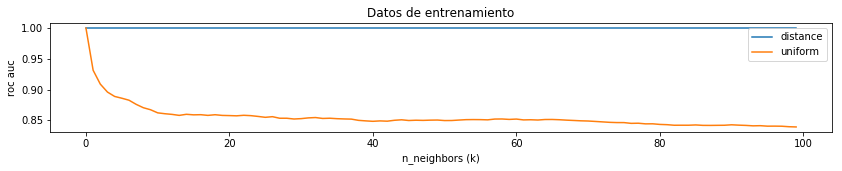

In [64]:
plt.figure(figsize=(14,2))
plt.plot(grid.cv_results_['mean_train_score'][grid.cv_results_['param_weights']=='distance'], label='distance')
plt.plot(grid.cv_results_['mean_train_score'][grid.cv_results_['param_weights']=='uniform'], label='uniform')
plt.legend()
plt.xlabel('n_neighbors (k)')
plt.ylabel('roc auc')
plt.title('Datos de entrenamiento')
plt.show()

A continuación probamos la métrica de distancia:

In [65]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
metrics= ['minkowski','euclidean', 'cityblock']
param_grid = dict(n_neighbors=n_neighbors, metric=metrics)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev.values, y_dev.values.ravel());

In [66]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8471 y se encontró para los parámetros {'metric': 'minkowski', 'n_neighbors': 63}
Modelo: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=63, p=2,
           weights='uniform')


En este caso, el *best score* sigue siendo similar al caso de buscar únicamente el número de vecinos. Incluso la mejor métrica para medir distancia es 'minkowski', es decir la de default. 

### Decision Tree

Utilizamos los mismos parámetros generales que en el caso anterior. Probaremos la *performance* del clasificador variando el tamaño de los árboles a través de *max_deph* y *min_sample_leaf*. El primer hiperparámetro define la profundidad máxima del árbol, y el último hiperparámetro fija el número mínimo de instancias necesarias para que se produzca una división. Estudiaremos además cómo cambia la performance con los criterios *Gini* y *Entropy*.

    Revisar el rango del min samples leaf en la bibliografia porque capaz le estamos dando mucho y tarda. Y ver otros hparametros y sus interpretaciones. Vale la pena poner todo esto si hacemos que cierre algun concepto sobre arboles.
    
    El max leaf nodes conviene bajo, el min samples split y el min samples leaf convienen mas altos

In [67]:
max_depth = list(range(1,30))
min_samples_leaf = list(range(1,101))
criterion = ['gini', 'entropy']
param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion=criterion)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

A continuación vemos que  el mejor estimador en este caso viene dado por profundidad máxima de 5, min_samples_leaf 30 y criterio de la información para separar nodos:

In [68]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.7632 y se encontró para los parámetros {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 19}
Modelo: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Veamos que sucede estudiando un parámetro a la vez con Grid Search:

In [69]:
# solo max depth
max_depth = list(range(1,30))
criterion = ['gini', 'entropy']
param_grid = dict(max_depth=max_depth, criterion=criterion)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [70]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.7309 y se encontró para los parámetros {'criterion': 'gini', 'max_depth': 3}
Modelo: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [71]:
# solo con min leaf 
min_samples_leaf = list(range(1,101))
criterion = ['gini', 'entropy']
param_grid = dict(min_samples_leaf=min_samples_leaf, criterion=criterion)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
tree = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [72]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.7523 y se encontró para los parámetros {'criterion': 'gini', 'min_samples_leaf': 29}
Modelo: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=29, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Comparando *best scores* vemos que con el primer caso (profundidad máxima y mínimo de samples por hoja) se obtiene un resultado semejante al 3ero, en el cual sólo se estudia la cantidad mínima de samples por hoja. Sin embargo, la altura máxima del primer caso (max_depth = 5) también es semejante respecto al segundo caso (max_depth = 4) a pesar de haber disminuido el *best_score*. En todos los casos, el criterio para una mejor clasificación fue la entropía.

### LDA

En este caso los hiperparámetros cuya combinación queres optimizar son: *n_components* y *solver*. Este último fija la técnica que aplicará el clasificador: descomposición en autovalores, cuadrados mínimos y descomposición en valores singulares (SVD - default).

    En los documents de sklearn dice que el n_components tiene que ser menor a (numero de clases-1). Y siempre nos esta dando 0. Pero le estamos dando un rango gigante. Me parece que no tiene sentido

In [73]:
solver = ['svd','lsqr','eigen']
n_components = list(range(0,201,20))
param_grid = dict(solver=solver, n_components=n_components)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [74]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.6627 y se encontró para los parámetros {'n_components': 0, 'solver': 'svd'}
Modelo: LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)


El mejor estimador viene dado por cero componentes y svd.

    Revisar otros hparametros y buscar alguno sobre el cual se pueda hacer una interpretacion piola. tolerancia (parece que es importante en svd pero no se que onda en los otros)? shrinkage (svd no tiene shrinkage pero lsqr o eigen si) ?

In [75]:
solver = ['lsqr','eigen']
shrinkage = np.linspace(0,1,11)
n_components = list(range(0,201,20))
param_grid = dict(n_components=n_components, shrinkage=shrinkage, solver=solver)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [76]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8423 y se encontró para los parámetros {'n_components': 0, 'shrinkage': 0.8, 'solver': 'lsqr'}
Modelo: LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=0.8,
              solver='lsqr', store_covariance=False, tol=0.0001)


In [77]:
tol = np.logspace(-16, -2, 15)
param_grid = dict(tol=tol)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [78]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.6627 y se encontró para los parámetros {'tol': 1e-16}
Modelo: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=1e-16)


    Valores mas altos de tolerancia no se los banca y me tira un warning de que las variables son colineales. Y a medida que le agrego valores mas bajos me elige cada vez el mas chico, pero la performance es la misma (o al menos la misma para 4 decimales)

Ultima chance para n components

In [79]:
solver = ['svd','lsqr','eigen']
n_components = list(range(0,21))
param_grid = dict(solver=solver, n_components=n_components)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
grid = sklearn.model_selection.GridSearchCV(lda,param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.6627 y se encontró para los parámetros {'n_components': 0, 'solver': 'svd'}
Modelo: LinearDiscriminantAnalysis(n_components=0, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)


No tiene sentido hacer un grid sobre n components. La posta es probar los solvers lsqr y eigen y meterle shrinkage. Pero estaria bueno tener una minima idea de lo que es

### Naive Bayes

En este caso no contamos con información de los Minions que nos permitan introducir un prior como hiperparámetro a variar. Sin embargo tenemos el var_smoothing que es: Portion of the largest variance of all features that is added to variances for calculation stability

In [80]:
var_smoothing = np.logspace(-10, 5, 16)
param_grid = dict(var_smoothing=var_smoothing)
nb = sklearn.naive_bayes.GaussianNB()
#nb.fit(X_dev, y_dev.values.ravel())
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(nb, param_grid=param_grid, cv=cv, scoring='roc_auc', iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [81]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8296 y se encontró para los parámetros {'var_smoothing': 10.0}
Modelo: GaussianNB(priors=None, var_smoothing=10.0)


    Tendría sentido agregar como prior algun criterio que diga cuan buen dato es cada instancia? por ejemplo el resultado de un test de normalidad sobre los valores de todos los atributos o alguna locura de esas?

### SVM

    Revisar toda esta parte. Capaz que conviene poner el linearsvc que nos recomendaron y meterse en menos quilombos de hparametros con el kernel y todo eso

En este caso usaremos como hiperparámetros a C (penalidades de error) y el tipo de kernel (no con la opcion *precomputed* ya que requiere que X_dev sea una matriz cuadrada).

In [ ]:
C_range = np.logspace(-2, 5, 8)
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
#gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(kernel=kernel, C=C_range)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [ ]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor estimador viene dado por el kernel de default (rbf) y C = 10. Veamos variando C y el rango de gamma:

In [ ]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel())

In [ ]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

En este caso el *best score* esta por debajo del caso anterior con gamma = auto.

    El linear svc tiene muchos problemas de convergencia. Y no me deja usar ni regularizacion ni funciones costo

In [82]:
C = np.logspace(-2, 5, 8)
tol = np.logspace(-10, 5, 16)
#verbose = [0, 1, 2]
#max_iter = [1000, 2000, 5000, 10000]
#penalty = ['l1','l2']
#loss = ['hinge','squared_hinge']
#dual = ['True','False']
#param_grid = dict(C=C, tol=tol, penalty=penalty, loss=loss, dual=dual, max_iter=max_iter, verbose=verbose)
param_grid = dict(C=C, tol=tol)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
#svm = sklearn.svm.LinearSVC()
svm = sklearn.svm.LinearSVC(max_iter=5000)
grid = sklearn.model_selection.GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [83]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)
#### O tambien
#print('El mejor valor de roc auc es de %0.4f y se encontró para los parámetros %s'
#      % (grid.best_score_, grid.best_params_))
#print('Modelo: %s' % (grid.best_estimator_))

El mejor valor de roc auc es de 0.8238 y se encontró para los parámetros {'C': 100.0, 'tol': 100.0}
Modelo: LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=100.0,
     verbose=0)


Y para ver los resultados hago heatmaps

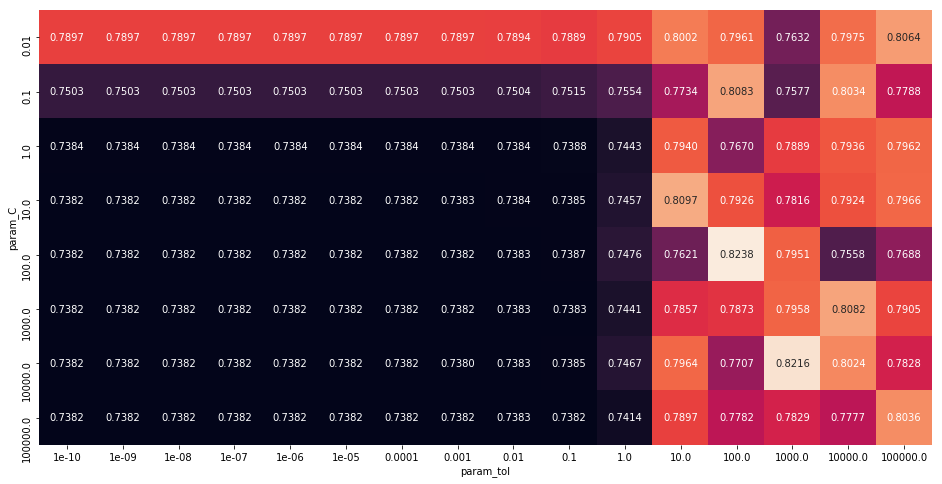

In [84]:
pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', index='param_C', columns='param_tol')  
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(pvt, square=False, annot=True, fmt=".4f", cbar=False)
plt.show()

    Pruebo con svm svc con kernel lineal

In [85]:
C = np.logspace(-10, 5, 16)
tol = np.logspace(-10, 5, 16)
param_grid = dict(C=C, tol=tol)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
svm = sklearn.svm.SVC(kernel='linear')
grid = sklearn.model_selection.GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel());

In [86]:
print_grid(grid)
#print('El mejor valor de roc auc es de {:.4f} y se encontró para los parámetros {}'.format(grid.best_score_,str(grid.best_params_)))
#print('Modelo:', grid.best_estimator_)

El mejor valor de roc auc es de 0.8428 y se encontró para los parámetros {'C': 0.001, 'tol': 1e-10}
Modelo: SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=1e-10, verbose=False)


Y para ver los resultados hago heatmap

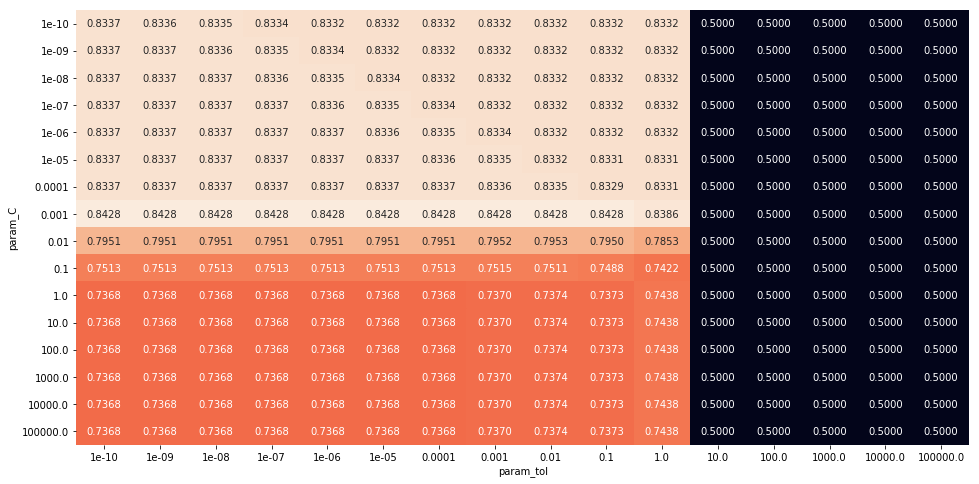

In [87]:
pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', index='param_C', columns='param_tol') 
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(pvt, square=False, annot=True, fmt=".4f", cbar=False)
plt.show()

<a name="gridsearch"></a>
### 3.2. Grid Search CV

In [ ]:
def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

In [88]:
# estimadores
knn = sklearn.neighbors.KNeighborsClassifier()
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
tree = sklearn.tree.DecisionTreeClassifier()
nb = sklearn.naive_bayes.GaussianNB()
#svm = sklearn.svm.LinearSVC()
svm = sklearn.svm.SVC(kernel='linear')
# parametros
param_grid_knn = {'n_neighbors': list(range(1, 101))}
param_grid_lda = {'solver': ['lsqr','eigen'], 'shrinkage': np.linspace(0,1,11)}
param_grid_tree = {'max_depth': list(range(1,21)), 'criterion': ['gini', 'entropy']}
param_grid_nb = {'var_smoothing': np.logspace(-10, 5, 16)}
param_grid_svm = {'C': np.logspace(-10, 5, 16), 'tol': np.logspace(-10, 5, 16)}
# cv
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid_knn = sklearn.model_selection.GridSearchCV(knn, param_grid=param_grid_knn, scoring='roc_auc', cv=cv, iid='True')
grid_knn.fit(X_dev, y_dev.values.ravel());
grid_lda = sklearn.model_selection.GridSearchCV(lda, param_grid=param_grid_lda, scoring='roc_auc', cv=cv, iid='True')
grid_lda.fit(X_dev, y_dev.values.ravel());
grid_tree = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid_tree, scoring='roc_auc', cv=cv, iid='True')
grid_tree.fit(X_dev, y_dev.values.ravel());
grid_nb = sklearn.model_selection.GridSearchCV(nb, param_grid=param_grid_nb, scoring='roc_auc', cv=cv, iid='True')
grid_nb.fit(X_dev, y_dev.values.ravel());
grid_svm = sklearn.model_selection.GridSearchCV(svm, param_grid=param_grid_svm, scoring='roc_auc', cv=cv, iid='True')
grid_svm.fit(X_dev, y_dev.values.ravel());

In [89]:
print('KNN')
top_resultados(grid_knn)
print('LDA')
top_resultados(grid_lda)
print('Tree')
top_resultados(grid_tree)
print('NB')
top_resultados(grid_nb)
print('SVM')
top_resultados(grid_svm)

KNN
Top 5 combinaciones


,n_neighbors,mean_score_validation,mean_score_training
62,63,0.8471,0.8511
59,60,0.8461,0.8517
60,61,0.8461,0.8522
61,62,0.8454,0.8509
63,64,0.8433,0.8507


LDA
Top 5 combinaciones


,shrinkage,solver,mean_score_validation,mean_score_training
16,0.8,lsqr,0.8423,0.9258
17,0.8,eigen,0.8419,0.9262
15,0.7,eigen,0.8397,0.9454
14,0.7,lsqr,0.8395,0.9453
19,0.9,eigen,0.8390,0.8976


Tree
Top 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
2,gini,3,0.7309,0.8826
23,entropy,4,0.7265,0.9512
22,entropy,3,0.7257,0.8844
1,gini,2,0.7230,0.8107
21,entropy,2,0.7138,0.8106


NB
Top 5 combinaciones


,var_smoothing,mean_score_validation,mean_score_training
11,10.0,0.8296,0.8526
13,1000.0,0.8292,0.8511
14,10000.0,0.8292,0.8511
15,100000.0,0.8292,0.8511
9,0.1,0.8291,0.8667


SVM
Top 5 combinaciones


,C,tol,mean_score_validation,mean_score_training
119,0.001,1.0000e-03,0.8428,0.9042
118,0.001,1.0000e-04,0.8428,0.9042
117,0.001,1.0000e-05,0.8428,0.9042
116,0.001,1.0000e-06,0.8428,0.9042
115,0.001,1.0000e-07,0.8428,0.9042


#### Conclusiones Grid Search

< < COMPLETAR > >

<a name="randomizedsearch"></a>
### 3.3. Randomized Search CV 

    Ver como meter distribuciones

### KNN

In [ ]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=n_neighbors, weights=weights)
rand = sklearn.model_selection.RandomizedSearchCV(knn, param_dist, cv=5, scoring='roc_auc', n_iter=10, iid='True')
rand.fit(X_dev.values, y_dev.values.ravel())
#rand.grid_scores_

In [ ]:
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

In [ ]:
best_scores = []
best_n = []
#n_neighbors = list(range(1, 101))
n_neighbors = [1, 30, 101]
#weights = ['uniform', 'distance']
#param_dist = dict(n_neighbors=n_neighbors, weights=weights)
param_dist = dict(n_neighbors=n_neighbors)
for _ in list(range(20)):
    knn = KNeighborsClassifier()
    rand = sklearn.model_selection.RandomizedSearchCV(knn, param_distributions=param_dist, cv=5, scoring='roc_auc', n_iter=10, iid='True')
    rand.fit(X_dev.values, y_dev.values.ravel())
    best_scores.append(rand.best_score_)
    best_n.append(rand.best_params_['n_neighbors'])
print(best_scores)
print(best_n)

In [ ]:
plt.hist(best_n);

In [ ]:
print("mean: {}".format(np.mean(best_n)))
print("std: {:.2f}".format(np.std(best_n)))
print("median: ", np.median(best_n))

In [ ]:
best_n = []
n_neighbors = list(range(1, 101))
weights = ['uniform', 'distance']
param_dist = dict(n_neighbors=n_neighbors, weights=weights)
n_iter = np.linspace(10,100,4)
for n in n_iter:
    for _ in list(range(10)):
        knn = KNeighborsClassifier()
        rand = sklearn.model_selection.RandomizedSearchCV(knn, param_dist, cv=5, scoring='roc_auc', n_iter=n, iid='True')
        rand.fit(X_dev.values, y_dev.values.ravel())
        best_scores.append(rand.best_score_)
        best_n.append(rand.best_params_['n_neighbors'])    

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(n_iter,np.array(best_n).reshape(len(n_iter),10))
plt.xlabel('n_iter', fontsize=12)
plt.ylabel('k', fontsize=12)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,10,10),np.array(best_n).reshape(len(n_iter),10).T)
plt.xlabel('runs', fontsize=12)
plt.ylabel('k', fontsize=12)
plt.legend(n_iter, title='n_iter')
plt.show()

Habria que hacer la cuenta del tamaño de la grilla del grid search, en base a eso probar con varios n_iter y comparar tiempos. Seguro que encuentro que a partir de un n_iter empiezo a tener una solucion estable y ese es mucho menor que la cantidad de datos que exploro con la grilla. Ver de comparar tiempos de ejecucion

En el caso de que solo busquemos sintonizar el parametro k, para el grid tengo 100 y para el random podemos usar un n_iter=20 y estamos probando en la 5ta parte de los valores 

In [ ]:
knn = KNeighborsClassifier()
n_neighbors = list(range(1, 101))
param_grid = dict(n_neighbors=n_neighbors)
grid = sklearn.model_selection.GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', iid='True')
start = time()
grid.fit(X_dev.values, y_dev.values.ravel())
print('grid search took {:.2f} seconds'.format(time() - start))
print(grid.best_params_)
rand = sklearn.model_selection.RandomizedSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_iter=20, iid='True')
start = time()
rand.fit(X_dev.values, y_dev.values.ravel())
print('random search took {:.2f} seconds'.format(time() - start))
print(rand.best_params_)

## Ejercicio 4: 
<a name="diagnostico"></a>
## 4. Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).

----


<a name="complejidad"></a>
### 4.1. Curvas de complejidad 

### Tree

In [90]:
tree = sklearn.tree.DecisionTreeClassifier()
param_grid_tree = {'max_depth': list(range(1,21)), 'criterion': ['gini', 'entropy']}
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid = sklearn.model_selection.GridSearchCV(tree, param_grid=param_grid_tree, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel());

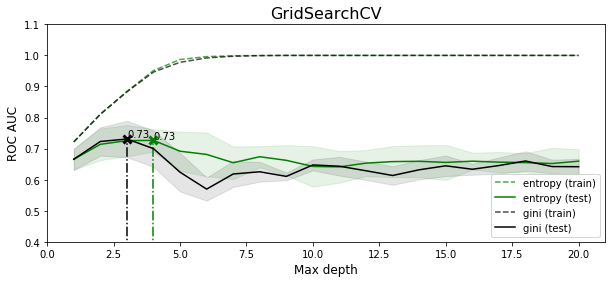

In [92]:
criterion = ['gini','entropy']
max_depth = range(1,21)

plt.figure(figsize=(10, 4))
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel("Max depth", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)

ax = plt.gca()
ax.set_xlim(0, 21)
ax.set_ylim(0.4, 1.1)

for criterio, color in zip(sorted(criterion), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = grid.cv_results_['mean_%s_score' % (sample)][np.array(grid.cv_results_['param_criterion']) == criterio]
        sample_score_std = grid.cv_results_['std_%s_score' % (sample)][np.array(grid.cv_results_['param_criterion']) == criterio]
        ax.fill_between(max_depth, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(max_depth, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (criterio, sample))

    best_index = np.argmax(grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_criterion']) == criterio])
    best_score = grid.cv_results_['mean_test_score'][np.array(grid.cv_results_['param_criterion']) == criterio][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([max_depth[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (max_depth[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


### SVM

Uso tol 1e-03 aunque todos me daban igual

In [93]:
C = np.logspace(-10, 5, 16)
param_grid = dict(C=C)
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
svm = sklearn.svm.SVC(kernel='linear', tol=1e-03)
grid = sklearn.model_selection.GridSearchCV(svm, param_grid=param_grid, scoring='roc_auc', cv=cv, iid='True')
grid.fit(X_dev, y_dev.values.ravel());

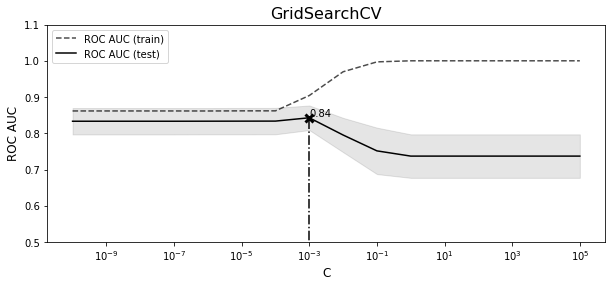

In [94]:
plt.figure(figsize=(10, 4))
plt.title("GridSearchCV",
          fontsize=16)

plt.xlabel("C", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)

ax = plt.gca()
#ax.set_xlim(0, 101)
ax.set_ylim(0.5, 1.1)

X_axis = np.array(grid.cv_results_['param_C'].data, dtype=float)

for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = grid.cv_results_['mean_%s_score' % (sample)]
    sample_score_std = grid.cv_results_['std_%s_score' % (sample)]
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color='k')
#    ax.plot(X_axis, sample_score_mean, style,
    ax.semilogx(X_axis, sample_score_mean, style,
            alpha=1 if sample == 'test' else 0.7, color='k',
            label="ROC AUC (%s)" % (sample))

best_index = np.nonzero(grid.cv_results_['rank_test_score'] == 1)[0][0]
best_score = grid.cv_results_['mean_test_score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [0, best_score],
        linestyle='-.', marker='x', markeredgewidth=3, ms=8, color='k')

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
#plt.grid('off')
plt.show()


<a name="aprendizaje"></a>
### 4.2. Curvas de aprendizaje 

### Tree

In [95]:
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
tree = sklearn.tree.DecisionTreeClassifier(max_depth=3, criterion='gini')
train_sizes = [range(20, 301, 5)]
train_sizes, train_scores, valid_scores = sklearn.model_selection.learning_curve(tree, X=X_dev.values, y=y_dev.values.ravel(), train_sizes=train_sizes, cv=cv, scoring='roc_auc')

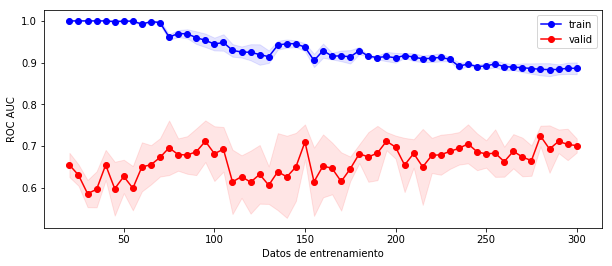

In [96]:
plt.figure(figsize=(10,4))
for sample, color in zip(('train','valid'), ['b','r']):
    sample_score_mean = eval('%s_scores.mean(axis=1)' % sample)
    sample_score_std = eval('%s_scores.std(axis=1)' % sample)
    plt.fill_between(train_sizes, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 , color=color)
    plt.plot(train_sizes, sample_score_mean, 'o-', color=color, label=sample)
plt.ylabel('ROC AUC')
plt.xlabel('Datos de entrenamiento')
plt.legend()
plt.show()

### SVM

In [97]:
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
svm = sklearn.svm.SVC(kernel='linear', tol=1e-03, C=1e-03)
train_sizes = [range(20, 301, 5)]
train_sizes, train_scores, valid_scores = sklearn.model_selection.learning_curve(svm, X=X_dev.values, y=y_dev.values.ravel(), train_sizes=train_sizes, cv=cv, scoring='roc_auc')

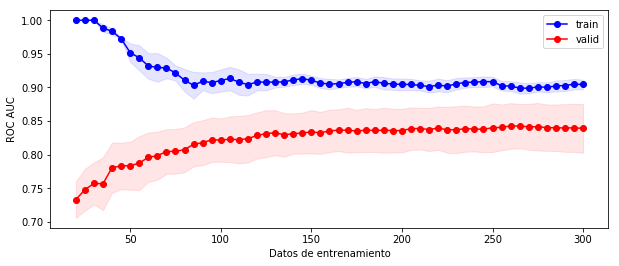

In [98]:
plt.figure(figsize=(10,4))
for sample, color in zip(('train','valid'), ['b','r']):
    sample_score_mean = eval('%s_scores.mean(axis=1)' % sample)
    sample_score_std = eval('%s_scores.std(axis=1)' % sample)
    plt.fill_between(train_sizes, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 , color=color)
    plt.plot(train_sizes, sample_score_mean, 'o-', color=color, label=sample)
plt.ylabel('ROC AUC')
plt.xlabel('Datos de entrenamiento')
plt.legend()
plt.show()

<a name="randomforest"></a>
### 4.3. Ensambles: Random Forest

Defino un clasificador de Random Forest con 200 árboles

In [99]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


El hiperparámetro max_features define el tamaño máximo del subset de atributos considerados para la decisión de cada nodo. El valor seteado por default es la raíz cuadrada del total de atributos

In [100]:
np.sqrt(X_dev.shape[1])

14.142135623730951

Elegimos una grilla de max_features posibles

In [101]:
param_grid_rf = {'max_features': list(range(1,20))}
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
grid_rf = sklearn.model_selection.GridSearchCV(rf, param_grid=param_grid_rf, cv=cv, scoring='roc_auc', iid='True')
grid_rf.fit(X_dev.values, y_dev.values.ravel());

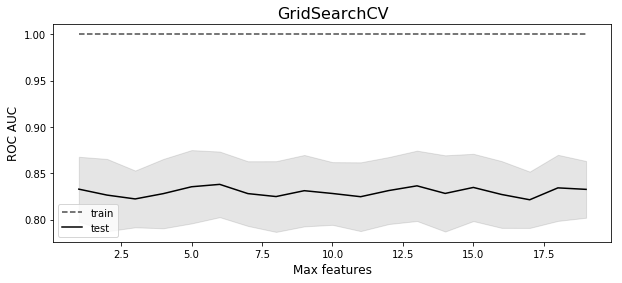

In [102]:
max_features = list(range(1,20))
color='k'

plt.figure(figsize=(10, 4))
for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = grid_rf.cv_results_['mean_%s_score' % (sample)]
    sample_score_std = grid_rf.cv_results_['std_%s_score' % (sample)]
    plt.fill_between(max_features, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color=color)
    plt.plot(max_features, sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s" % (sample))

plt.title('GridSearchCV', fontsize=16)

plt.xlabel('Max features', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.legend()
#plt.grid('off')
plt.show()

Como el max_depth por default está definido como None, esto significa que no estoy imponiendo una altura máxima de los árboles, y los nodos se expanden hasta que todas las hojas son puras o hasta que todas las hojas tienen menos instancias que el valor de min_samples_split. El valor de min_samples_split por default es igual a 2, por lo que los árboles son muy profundos. El modelo resulta entonces muy específico y está sobreajustado a los datos de entrenamiento. Por eso es que el score sobre los datos de entrenamiento da siempre 1 y el score sobre los datos de testeo es más bajo. Sin embargo, el score sobre los datos de testeo es bastante alto respecto a los valores obtenidos para los árboles de decisión individuales estudiados en la sección previa.

    Ver bagging o el tema de que el rf baja la varianza y mejora la capacidad de prediccion

Entonces probamos varios valores de max_depth

In [103]:
param_grid_rf = {'max_features': list(range(1,20)), 'max_depth': [3,5,10]}
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
grid_rf = sklearn.model_selection.GridSearchCV(rf, param_grid=param_grid_rf, cv=cv, scoring='roc_auc', iid='True')
grid_rf.fit(X_dev.values, y_dev.values.ravel());

In [104]:
grid_rf.cv_results_['mean_train_score']

array([0.9787, 0.961 , 0.9571, 0.9512, 0.9463, 0.9479, 0.9469, 0.9472,
       0.9476, 0.9506, 0.951 , 0.9495, 0.9502, 0.952 , 0.9523, 0.9535,
       0.9562, 0.9557, 0.9554, 0.998 , 0.997 , 0.9969, 0.997 , 0.9978,
       0.9976, 0.9982, 0.9983, 0.9989, 0.9989, 0.9991, 0.999 , 0.999 ,
       0.9994, 0.9994, 0.9994, 0.9993, 0.9993, 0.9996, 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    ])

Definimos max_depth=3, que es un valor bajo de manera tal de que los árboles sean modelos débiles, pero que del ensamble salga un modelo fuerte

In [105]:
param_grid_rf = {'max_features': list(range(1,20))}
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=3)
grid_rf = sklearn.model_selection.GridSearchCV(rf, param_grid=param_grid_rf, cv=cv, scoring='roc_auc', iid='True')
grid_rf.fit(X_dev.values, y_dev.values.ravel());

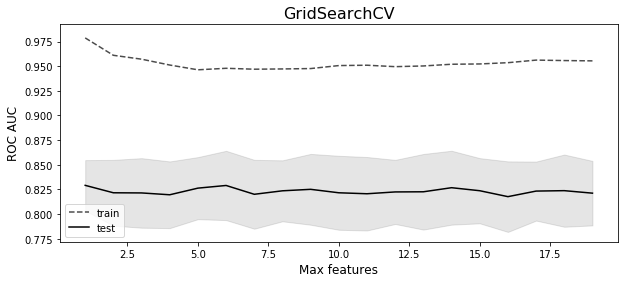

In [106]:
max_features = list(range(1,20))
color='k'

plt.figure(figsize=(10, 4))
for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = grid_rf.cv_results_['mean_%s_score' % (sample)]
    sample_score_std = grid_rf.cv_results_['std_%s_score' % (sample)]
    plt.fill_between(max_features, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color=color)
    plt.plot(max_features, sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0.7,
            label="%s" % (sample))

plt.title('GridSearchCV', fontsize=16)

plt.xlabel('Max features', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.legend()
#plt.grid('off')
plt.show()

    Habría que ver si se pueden sintonizar mejor algunos parámetros o si se pueden simplificar más los árboles. Si no, lo que decimos es que aunque tengamos más datos, el clasificador no va a mejorar por el tema sesgo-varianza

Curva de aprendizaje

In [107]:
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=3, max_features=np.sqrt(X_dev.shape[1]))
train_sizes = [range(20, 301, 5)]
train_sizes, train_scores, valid_scores = sklearn.model_selection.learning_curve(tree, X=X_dev.values, y=y_dev.values.ravel(), train_sizes=train_sizes, cv=cv, scoring='roc_auc')

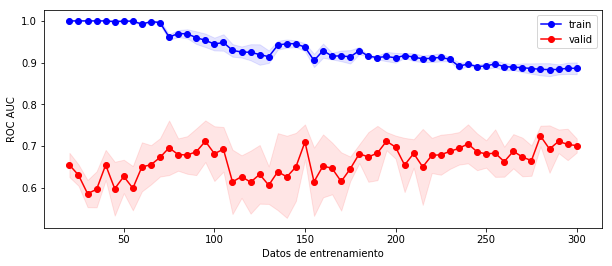

In [108]:
plt.figure(figsize=(10,4))
for sample, color in zip(('train','valid'), ['b','r']):
    sample_score_mean = eval('%s_scores.mean(axis=1)' % sample)
    sample_score_std = eval('%s_scores.std(axis=1)' % sample)
    plt.fill_between(train_sizes, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 , color=color)
    plt.plot(train_sizes, sample_score_mean, 'o-', color=color, label=sample)
plt.ylabel('ROC AUC')
plt.xlabel('Datos de entrenamiento')
plt.legend()
plt.show()

<a name="gradientboosting"></a>
### 4.4. Ensambles: Gradient Boosting

    Ver lo de randomized search con distribuciones y que hparametros hay que mejorar del gb

In [ ]:
gb = sklearnearnearn.ensemble.GradientBoostingClassifier()
gb_grid_params = {'n_estimators': [500, 600, 700, 800, 900, 1000]
                'learning_rate': [0.1, 0.05, 0.02, 0.01],
                'max_depth': [4, 6, 8],
                'min_samples_leaf': [20, 50,100,150],
                #'max_features': [1.0, 0.3, 0.1] 
                  }
np.random.seed(SEED)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5)
grid_gb = sklearn.model_selection.RandomizedSearchCV(rf, param_grid=param_grid_rf, cv=cv, scoring='roc_auc', iid='True')
grid_gb.fit(X_dev.values, y_dev.values.ravel())

<a name="competencia"></a>
## 5. Competencia

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


Los datos de la competencia van a tener la misma cantidad de atributos, pero van a ser de 4500 instancias

In [ ]:
X_competencia

Habria que ver que pasaria si usaran un balance distinto de datos para la competencia. O si el balance de los datos en el entrenamiento te condiciona mucho. Si los datos estan muy desbalanceados, es mas estable el auc de la curva precision recall? Igual los datos no estan casi desbalanceados. Pero si lo estuvieran, habria que ver si se le puede dar mas peso a la clase minoria, como pasa con logistic regression con el weight class. Aunque quizas splitear a ciegas es mejor para no meter proporcionalidad. Se podria ver como cambia el auc usando distintos grupos de hold out. O sea, el hold out total de 0.2 se lo puede dividir en 1 hold out de 0.1 y lo restante separarlo en 2 grupos completamente desbalanceados o en 3, agregando uno balanceado pero menor. De esa manera puedo hacer un análisis mas profundo para predecir cuanto va a dar la roc auc. Aunque el tema ahi es que pierdo tamaño del set. Y el X competencia es largo, tiene 4500 datos. Pero no sabemos si esta balanceado porque el y competencia que dieron es de ejemplo y el real lo tienen ellos.

Tambien, para predecir mejor que tan generalizable es el modelo, en lugar de separar el hold out set en varios independientes, se puede hacer bootstrapping. Manteniendo el mismo split y el mismo modelo, se pueden hacer subsets random del dev set y del holdout set y medir las aucs. Ahora no se va a tener un unico valor, si no que se va a tener una distribucion con su estadistica. Si defino que los subsets resampleados para el bootstrapping tengan el mismo stratify que el grupo total, voy a reducir la varianza producida por la estratificacion variable de los resamples. Pero quizas esto no es conveniente ya que en realidad no se si ellos van a usar una muestra igual de estratificada. Y deberia ser independiente de eso mi prediccion de cuan generalizable es el modelo.

Otra forma de ver generalizacion es repetir el proceso completo de split entrenamiento etc. Y entonces puedo sacar una estadistica, pero no voy a tener un unico modelo. Salvo que me quede con el modelo que tenga un auc igual a la mediana. Y esto esta bueno para ver como que tan distintos van a ser los modelos segun si elegi un split random especifico de casualidad u otro. Entonces puedo estudiar robustez. Y si me quedo con el modelo de la mediana, me puedo fijar la performance en train y test. Y capaz a ese modelo y split hacerle bootstrapping.

Otra cosa que se puede hacer es ver si el set de hold out tiene la misma info que el de entrenamiento. Para esto, se usa como "y" el set al que pertenece y se evalua un clasificador a ver si puede diferenciar ambos grupos. Si no puede, la info de los 2 grupos es la misma.


<a name="entrega"></a>
## 6. Entrega

- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.